In [1]:
import os
from os.path import join, dirname, exists
from datetime import date
from glob import glob

import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib import animation, rc
import seaborn as sns
import plotly as py
import plotly.express as px

import random
import nilearn
import nibabel

from tqdm import tqdm

import urllib

import torchvision
from torchvision import transforms
from torchvision import models, utils
import torchextractor as tx
import cv2
import argparse

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
from torch.autograd import Variable as V
from PIL import Image
from decord import VideoReader
from decord import cpu

## import mydef as my Class correction for projects
import mydef

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.9.0+cu111
Torchvision Version:  0.10.0+cu111


In [4]:
GA = mydef.GA()

OS : linux
Google Drive is detected!
Git directory is detected!


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
print(device)

cpu


In [6]:
torch.cuda.device_count()

2

In [7]:
torch.cuda.get_device_name()

'GeForce RTX 3090'

In [8]:
seed = 42

# Loading behavioural data

In [9]:
# subj = random.sample(GA.list_subj, k=1)[0]
subj = '01'
stage = 'late_practice'
run = random.sample(['r01', 'r02', 'r03'], k=1)[0]
print(subj, stage, run)

01 late_practice r01


In [10]:
gg = 'GA' if 'early' in stage else ('GB' if 'late' in stage else 'invalid')

In [11]:
suffix = 'fmri' if 'early' in stage else ('refmri' if 'late' in stage else 'invalid')
data = scipy.io.loadmat(GA.dir_behav+'/GA%s-%s.mat'%(subj,suffix))

---

In [7]:
data['A'].shape

(14, 2)

60 sec * ( 4 move + 4 stop ) = 480 sec


In [9]:
data['allData'][:,28800:].shape

(14, 203700)

In [12]:
temp = np.matmul(data['A'].T,data['allData'][:,28800:])

In [20]:
temp

array([[ 0.67551816,  0.67541474,  0.6747625 , ...,  1.4712502 ,
         1.4667603 ,  1.4668608 ],
       [-0.6419686 , -0.6465313 , -0.64649916, ..., -0.36044824,
        -0.3576762 , -0.35063392]], dtype=float32)

In [19]:
data['allXY']

array([[ -13.27482663,    5.17862281,   25.58709472, ..., -138.05887163,
        -138.71128142, -139.78531301],
       [ 141.87375784,   45.74518606,  -65.94149798, ...,  151.06984198,
         150.23626149,  149.1441679 ]])

In [21]:
beta = np.matmul(np.matmul(data['allXY'],temp.T), np.linalg.inv(np.matmul(temp, temp.T)))

In [22]:
beta

array([[ -92.56682596, -231.85314614],
       [ -20.48670285,  -51.52851718]])

In [23]:
data['allXY'] - np.matmul(beta, temp)

array([[-99.5866966 , -82.20069065, -61.84514705, ..., -85.44097135,
        -85.86629219, -85.29824461],
       [122.63320711,  26.26740879, -85.43098232, ..., 162.63754377,
        161.85481882, 161.12766271]])

---

# Loading fMRI data

In this section, we demonstrate how to load fMRI data for a given ROI. 

In [9]:
dir_pb02 = '/mnt/sda2/GA/fmri_data/preproc_data/'

1. pb02

In [6]:
img = nilearn.image.load_img(
    join(dir_pb02,'%s%s'%(gg, subj),'epi.volreg.%s%s.%s.nii.gz'%(gg,subj,run))
)

2. 3dLSS

In [10]:
img = nilearn.image.load_img(
    join(GA.dir_fmri, 'preproc_data', subj,'betasLSS.%s%s.%s.nii.gz'%(gg, subj, run))
)
img.shape

(72, 85, 72, 97)

### ROIs

In [22]:
GA.roi_imgs = {}

0. Full mask

In [23]:
# for subj in GA.list_subj:
#     for stage in ['early_practice', 'late_practice']:
#         gg = 'GA' if 'early' in stage else ('GB' if 'late' in stage else 'invalid')
#         GA.roi_imgs[gg+subj] = nilearn.image.load_img(join(GA.dir_mask,'full','full_mask.%s.nii.gz'%(gg+subj)))
GA.roi_imgs['fullmask'] = nilearn.image.load_img(join(GA.dir_mask,'full_mask.GAGB.nii.gz'))
GA.roi_imgs

{'fullmask': <nibabel.nifti1.Nifti1Image at 0x7f661594da90>}

1. Localizers

In [ ]:
path_list = sorted(glob(join(GA.dir_mask,'localizer','n200_*.nii')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    GA.roi_imgs[roi] = nilearn.image.load_img(path)
GA.roi_imgs

In [ ]:
key_list = ['n200_c1_L_Postcentral'
            , 'n200_c2_R_CerebellumIV-V'
            , 'n200_c3_R_Postcentral'
            , 'n200_c4_L_Putamen'
            , 'n200_c5_R_SMA'
            , 'n200_c6_R_CerebellumVIIIb'
            , 'n200_c7_L_Thalamus']
temp = {}
for key in key_list:
    temp[key] = GA.roi_imgs[key]
GA.roi_imgs = temp
GA.roi_imgs

2. Yeo 1 network

In [8]:
GA.load_fan()

dt = pd.DataFrame()
## yeo_17network == 1
for nn in [1]:
    dt = dt.append(GA.fan_info[(GA.fan_info.yeo_17network == nn)])
for idx in dt.index:
    nn = dt.loc[idx,'label']
    region = dt.loc[idx,'region']
    GA.roi_imgs[region] = GA.fan_imgs[str(nn)]
GA.roi_imgs

{'FuG_L_3_2': <nibabel.nifti1.Nifti1Image at 0x7f1d7c4ad5b0>,
 'FuG_R_3_2': <nibabel.nifti1.Nifti1Image at 0x7f1d7c4b4040>,
 'MVOcC_L_5_1': <nibabel.nifti1.Nifti1Image at 0x7f1d7c471940>,
 'MVOcC_R_5_1': <nibabel.nifti1.Nifti1Image at 0x7f1d7c46cd30>,
 'MVOcC_L_5_3': <nibabel.nifti1.Nifti1Image at 0x7f1d7c46ca30>,
 'MVOcC_R_5_3': <nibabel.nifti1.Nifti1Image at 0x7f1d7c53ef40>,
 'MVOcC_R_5_4': <nibabel.nifti1.Nifti1Image at 0x7f1d7c4755e0>,
 'LOcC_L_4_1': <nibabel.nifti1.Nifti1Image at 0x7f1d7c4754c0>,
 'LOcC_R_4_1': <nibabel.nifti1.Nifti1Image at 0x7f1d7c475190>,
 'LOcC_L_4_3': <nibabel.nifti1.Nifti1Image at 0x7f1d7c479eb0>,
 'LOcC_R_4_3': <nibabel.nifti1.Nifti1Image at 0x7f1d7c480dc0>,
 'LOcC_L_4_4': <nibabel.nifti1.Nifti1Image at 0x7f1d7c4798b0>,
 'LOcC_R_4_4': <nibabel.nifti1.Nifti1Image at 0x7f1d7c480430>,
 'LOcC_L_2_2': <nibabel.nifti1.Nifti1Image at 0x7f1d7c4792e0>}

Masking

In [12]:
roi = 'FuG_L_3_2'

In [13]:
masked_img = GA.fast_masking(img=img, roi=GA.roi_imgs[roi])
masked_img.shape

(97, 333)

Figure

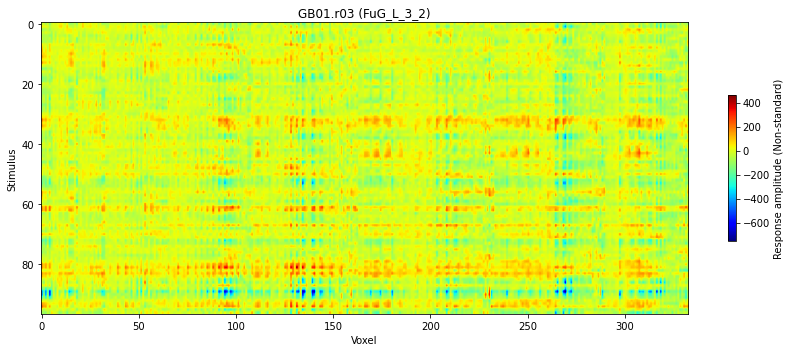

In [14]:
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus", title='%s%s.%s (%s)'%(gg, subj, run, roi))
heatmap = ax.imshow(masked_img, aspect="auto",cmap='jet')
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Non-standard)")
f.tight_layout()

The beta values were z-scored across stimulus (features).

In [15]:
masked_img = StandardScaler().fit_transform(masked_img)

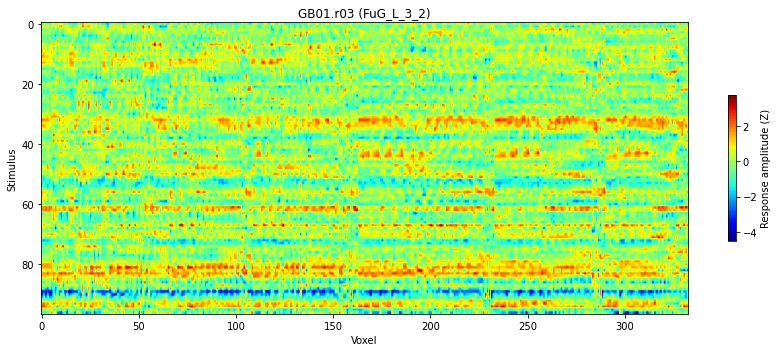

In [16]:
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus", title='%s%s.%s (%s)'%(gg, subj, run, roi))
heatmap = ax.imshow(masked_img, aspect="auto",cmap='jet')
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

# Loading videos

In [12]:
list_video = glob(join(GA.dir_work,'videos','*.mp4'))

In [13]:
from IPython.display import HTML
from base64 import b64encode

mp4 = open(join(GA.dir_work,'videos','20210914.%s%s.%s.mp4'%(gg, subj, run))
           , 'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
    <source src="%s" type="video/mp4">
</video>.3
""" % data_url)

In [8]:
def sample_video_from_mp4(vpath, num_frames=15):
    """This function takes a mp4 video vpath as input and returns
    a list of uniformly sampled frames (PIL Image).
    Parameters
    ----------
    vpath : str
        path to mp4 video vpath
    num_frames : int
        how many frames to select using uniform frame sampling.
    Returns
    -------
    images: list of PIL Images
    num_frames: int
        number of frames extracted
    """
    images = list()
    vr = VideoReader(vpath, ctx=cpu(0))
    total_frames = len(vr)
    indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
    for seg_ind in indices:
        images.append(Image.fromarray(vr[seg_ind].asnumpy()))

    return images, num_frames

---

In [15]:
video, num_frames = sample_video_from_mp4(vpath=join(GA.dir_work,'videos','20210914.%s%s.%s.mp4'%(gg, subj, run)), num_frames=int(29100*.25))

/tmp/ipykernel_519466/683694106.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)


In [16]:
video

[<PIL.Image.Image image mode=RGB size=500x500 at 0x7F93D5023250>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F954C376520>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F954C3768E0>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F954C376430>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F954C3725E0>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F954C321460>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F954C372580>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F92CB049D60>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F92CB049610>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F92CB049640>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F92CB049520>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F92CB049A90>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F92CB049F40>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F92CB049970>,
 <PIL.Image.Image image mode=RGB size=500x500 at 0x7F92CB049F70>,
 <PIL.Imag

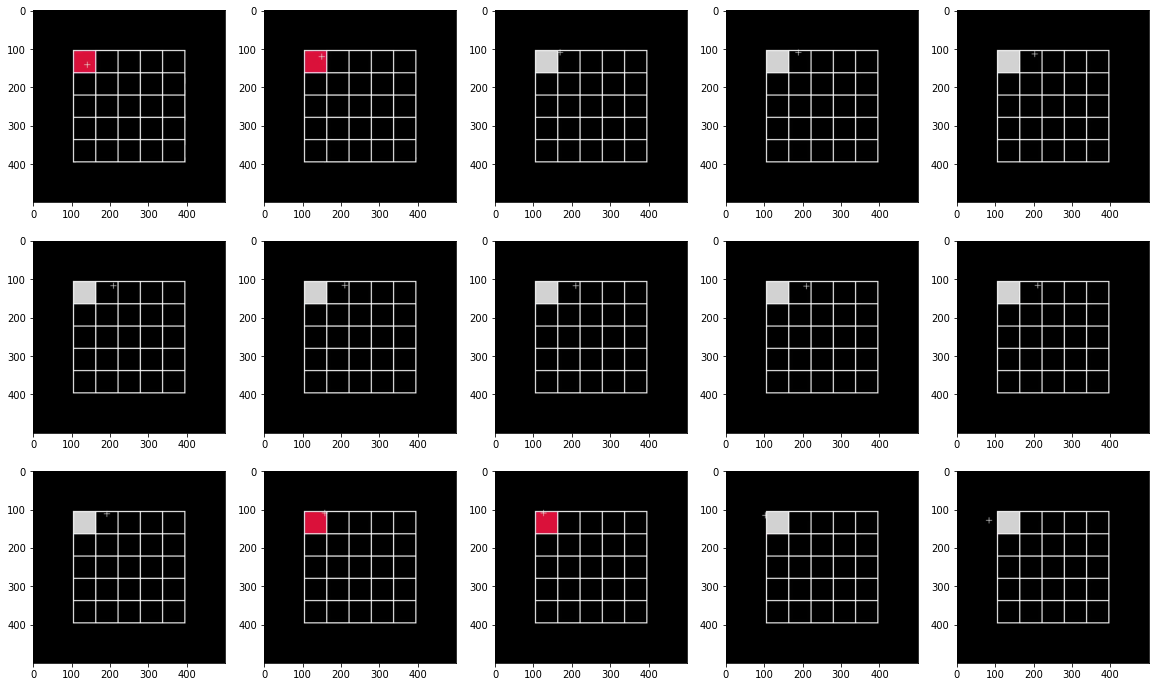

In [78]:
fig = plt.figure(figsize=(20, 12))

for i, img in enumerate(video[:15]):
    ax = fig.add_subplot(3, 5, i+1)
    plt.imshow(img)

---

# Vision model definition

In [9]:
## r2d
# model = models.resnet18(pretrained=True)
## r3d
# model = models.video.r3d_18(pretrained=True)
## vgg16
model = models.vgg16(pretrained=True)

In [14]:
from torchsummary import summary

print(device)
summary(model=model.to(device), input_size=(3, 224, 224), device=device)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# for param in model.parameters():
#     print(param.shape)

torch.Size([64, 3, 3, 3])


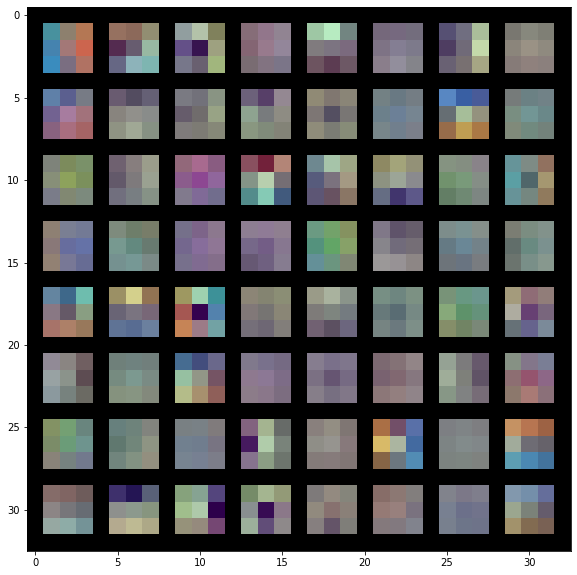

In [16]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# visualize the filters of the first CNN layer
for w in model.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# normalize weights
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = utils.make_grid(x_grid, nrow=8, padding=1)

plt.figure(figsize=(10, 10))
show(x_grid)

In [17]:
def vgg16(net, _input):
    outs = {}
    outs['1'] = net.features[:2](_input)
    outs['2'] = net.features[2:5](outs['1'])
    outs['3'] = net.features[5:7](outs['2'])
    outs['4'] = net.features[7:10](outs['3'])
    outs['5'] = net.features[10:12](outs['4'])
    outs['6'] = net.features[12:14](outs['5'])
    outs['7'] = net.features[14:17](outs['6'])
    outs['8'] = net.features[17:19](outs['7'])
    outs['9'] = net.features[19:21](outs['8'])
    outs['10'] = net.features[21:24](outs['9'])
    outs['11'] = net.features[24:26](outs['10'])
    outs['12'] = net.features[26:28](outs['11'])
    outs['13'] = net.features[28:](outs['12'])
    
    return outs

---

In [24]:
resize_normalize = transforms.Compose([
            transforms.Resize((224,224))
            , transforms.ToTensor()
            , transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [25]:
device = 'cuda'

In [26]:
model = models.vgg16(pretrained=True).to(device)

In [27]:
input_img = V(resize_normalize(video[0]).unsqueeze(0))
input_img = input_img.to(device)
input_img.shape

torch.Size([1, 3, 224, 224])

In [28]:
next(model.parameters()).is_cuda

True

In [29]:
input_img.is_cuda

True

In [30]:
_input = torch.rand(1,3,224,224).to(device)

In [31]:
_input.is_cuda

True

In [32]:
# model.features[:2](input_img).shape
# model(input_img).shape
model(_input).shape

torch.Size([1, 1000])

---

# Feature extraction

In [13]:
#@title Functions for loading videos and extracting features
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

def get_activations_and_save(model, subj, stage, run, dir_activation, ITI=5, down_sample = 0.25, device=device):
    ## down sampling: 60Hz * 0.25

    gg = 'GA' if 'early' in stage else ('GB' if 'late' in stage else 'invalid')
    model.to(device)
    
    resize_normalize = transforms.Compose([
            transforms.Resize((224,224))
            , transforms.ToTensor()
            , transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    ## a number of total frames: 29100
    total_frame = int(60*5*97)
    
    ## a number of frames per trial
    nframe = int(total_frame*down_sample/97.)
    
    output_dir = join(dir_activation, subj)
    os.makedirs(output_dir, exist_ok=True)

    video, num_frames = sample_video_from_mp4(
        vpath=join(GA.dir_work,'videos','20210914.%s%s.%s.mp4'%(gg, subj, run))
        , num_frames=int(total_frame*down_sample)
    )
    trial = 0
    for frame, img in enumerate(tqdm(video)):
        ## is it the 1st frame of each trial?
        is_1st = frame % (down_sample*60*ITI) == 0
        ## is it the last frame of each trial?
        is_last = (frame+1) % (down_sample*60*ITI) == 0

        ## at the 1st frame of a trial
        if is_1st:
            trial += 1
            activations = []

#         if trial != 84:
#             continue
            
        input_img = V(resize_normalize(img).unsqueeze(0))
        input_img = input_img.to(device)

        out = vgg16(net=model, _input=input_img)
        for i, feature in out.items():
            if is_1st:
                activations.append(feature.data.cpu().numpy().ravel())
            else:
                activations[int(i)-1] =  activations[int(i)-1] + feature.data.cpu().numpy().ravel()

        ## at the end of a trial
        if is_last:
            for layer in range(len(activations)):
                avg_layer_activation = activations[layer]/float(down_sample*60*ITI)
                np.save(
                    join(output_dir,"%s.%s.trial%02d.layer%02d.nframe%03d.npy"%(stage,run,trial,layer+1,nframe))
                    , avg_layer_activation
                )


In [14]:
model = _models['vgg16'].to(device)
# next(model.parameters()).is_cuda

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/torch/cuda/__init__.py:106: UserWarning: 
GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [17]:
# print('Total Number of Videos: ', len(list_video))

# # get and save activations
dir_activation = join(GA.dir_work,'results','activations','vgg16')
os.makedirs(dir_activation, exist_ok=True)
print("-------------Saving activations ----------------------------")
for run in ['r01', 'r02', 'r03']:
    print(run)
    get_activations_and_save(
        model=model, subj='02', stage='late_practice', run=run
        , dir_activation=dir_activation, down_sample=.25, device='cuda')

-------------Saving activations ----------------------------
r01


/tmp/ipykernel_500424/683694106.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = np.linspace(0,total_frames-1,num_frames,dtype=np.int)
  0%|          | 0/7275 [00:00<?, ?it/s]


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [9]:
dir_activation = join(GA.dir_work, 'results', 'activations', 'vgg16')

In [ ]:
run = 'r01'
trials = ['trial%02d'%(i+1) for i in range(97)]
layers = ['layer%02d'%(i+1) for i in range(5)]

for layer in layers:
    for trial in trials:
        i = np.load(join(dir_activation,'01.backup','late_practice.%s.%s.%s.nframe075.npy'%(run,trial,layer)))
        f = np.load(join(dir_activation,'01','GB01.%s.%s.%s.nframe075.npy'%(run,trial,layer)))
        print(layer, trial, np.abs(i-f).sum())

layer01 trial01 0.40211844
layer01 trial02 0.40331936
layer01 trial03 0.4021836
layer01 trial04 0.4022526
layer01 trial05 0.3994605
layer01 trial06 0.40222675
layer01 trial07 0.40258968
layer01 trial08 0.40224725
layer01 trial09 0.40364674
layer01 trial10 0.40622652
layer01 trial11 0.40293995
layer01 trial12 0.40183577
layer01 trial13 0.4009555
layer01 trial14 0.4000402
layer01 trial15 0.40306234
layer01 trial16 0.40253094
layer01 trial17 0.40152085
layer01 trial18 0.40112767
layer01 trial19 0.40309694
layer01 trial20 0.40266025
layer01 trial21 0.40312958
layer01 trial22 0.40116754
layer01 trial23 0.4000063
layer01 trial24 0.40284148
layer01 trial25 0.4019215
layer01 trial26 0.4043354
layer01 trial27 0.40330455
layer01 trial28 0.40222535
layer01 trial29 0.40020385
layer01 trial30 0.40102214
layer01 trial31 0.40303835
layer01 trial32 0.40179777
layer01 trial33 0.402947
layer01 trial34 0.40133005
layer01 trial35 0.4024201
layer01 trial36 0.4027011
layer01 trial37 0.40176347
layer01 trial

In [33]:
i

array([0.99304116, 2.5355215 , 3.6139688 , ..., 0.38111925, 1.311811  ,
       0.        ], dtype=float32)

In [34]:
f

array([0.99303895, 2.5355215 , 3.613967  , ..., 0.38112408, 1.3118153 ,
       0.        ], dtype=float32)

In [ ]:
i = np.load(join(dir_activation,'01.backup','late_practice.%s.%s.%s.nframe075.npy'%(run,trial,layer)))
f = np.load(join(dir_activation,'01','GB01.%s.%s.%s.nframe075.npy'%(run,trial,layer)))

# PCA

In [24]:
# runs = np.array(['r01', 'r02', 'r03'])
# loo = LeaveOneOut()
# for idx_train, idx_test in loo.split(runs):
#     print("%s %s" % (runs[idx_train], runs[idx_test]))

['r02' 'r03'] ['r01']
['r01' 'r03'] ['r02']
['r01' 'r02'] ['r03']


In [23]:
def do_PCA_and_save(dir_activation, stage, layer, dir_save, nframe, n_components=97):

    os.makedirs(dir_save, exist_ok=True)
    runs = ['r01', 'r02', 'r03'] if 'practice' in stage else (['r04', 'r05', 'r06'] if 'unpractice' in stage else 'invalid')
    runs = np.array(runs)

    loo = LeaveOneOut()
    for idx_train, idx_test in loo.split(runs):
        ## test
        activations_file_list = glob(join(dir_activation,'%s.%s.*.%s.nframe%03d.npy'%(stage,runs[idx_test][0],layer,nframe)))
        activations_file_list.sort()
        
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp

        x = StandardScaler().fit_transform(x)
        ipca = PCA(n_components=n_components,random_state=seed)
        x = ipca.fit_transform(x)
        np.save(join(dir_save,"%s.%s.nframe%03d"%(runs[idx_test][0],layer,nframe)), x)
        np.save(join(dir_save,"%s.%s.nframe%03d.explained_ratio"%(runs[idx_test][0],layer,nframe)), ipca.explained_variance_ratio_)
        
        ## train
        activations_file_list = []
        for run in runs[idx_train]:
            activations_file_list.append(glob(join(dir_activation,'%s.%s.*.%s.nframe%03d.npy'%(stage,run,layer,nframe))))
        activations_file_list = np.concatenate(activations_file_list)
        activations_file_list.sort()
        
        feature_dim = np.load(activations_file_list[0])
        x = np.zeros((len(activations_file_list),feature_dim.shape[0]))
        for i,activation_file in enumerate(activations_file_list):
            temp = np.load(activation_file)
            x[i,:] = temp

        x = StandardScaler().fit_transform(x)
        ipca = PCA(n_components=n_components,random_state=seed)
        x = ipca.fit_transform(x)
        np.save(join(dir_save,"%sc.%s.nframe%03d"%(runs[idx_test][0],layer,nframe)), x)
        np.save(join(dir_save,"%sc.%s.nframe%03d.explained_ratio"%(runs[idx_test][0],layer,nframe)), ipca.explained_variance_ratio_)

In [1]:
layers = ['layer%02d'%(i+1) for i in range(13)]

In [4]:
tmp = []
for subj in GA.list_subj:
    for layer in layers:
        tmp.append([subj, layer])
tmp = np.array(tmp)
tmp.shape

(390, 2)

In [ ]:
subj = '01'
stage = 'late_practice'
# preprocessing using PCA and save
dir_activation = join(GA.dir_work,'results','activations','vgg16', subj)
dir_save = join(GA.dir_work,'results','activations','vgg16','pca', subj)

print("-------------performing  PCA----------------------------")
for layer in tqdm(layers):
    do_PCA_and_save(dir_activation, stage, layer, dir_save, nframe=75)

-------------performing  PCA----------------------------


  0%|          | 0/13 [00:00<?, ?it/s]

# Voxel Wise Encoding

The approach has three steps: 

1. Features of a computer vision model to videos are extracted (Fig. 1A). This changes the format of the data (from pixels to model features) and typically reduces the dimensionality of the data. The features of a given model are interpreted as a potential hypothesis about the features that a given brain area might be using to represent the stimulus. 
2. Features of the computational model are linearly mapped onto each voxel's responses (Fig. 1B) using the training set provided. This step is necessary as there is not necessarily a one-to-one mapping between voxels and model features. Instead, each voxel's response is hypothesized to correspond to a weighted combination of activations of multiple features of the model. 
3. The estimated mapping from the training dataset is applied on the model features corresponding to videos in the test set to predict synthetic brain data (Fig. 1C). The predicted synthetic brain data is then compared against the ground-truth left out brain data in the testing set. 

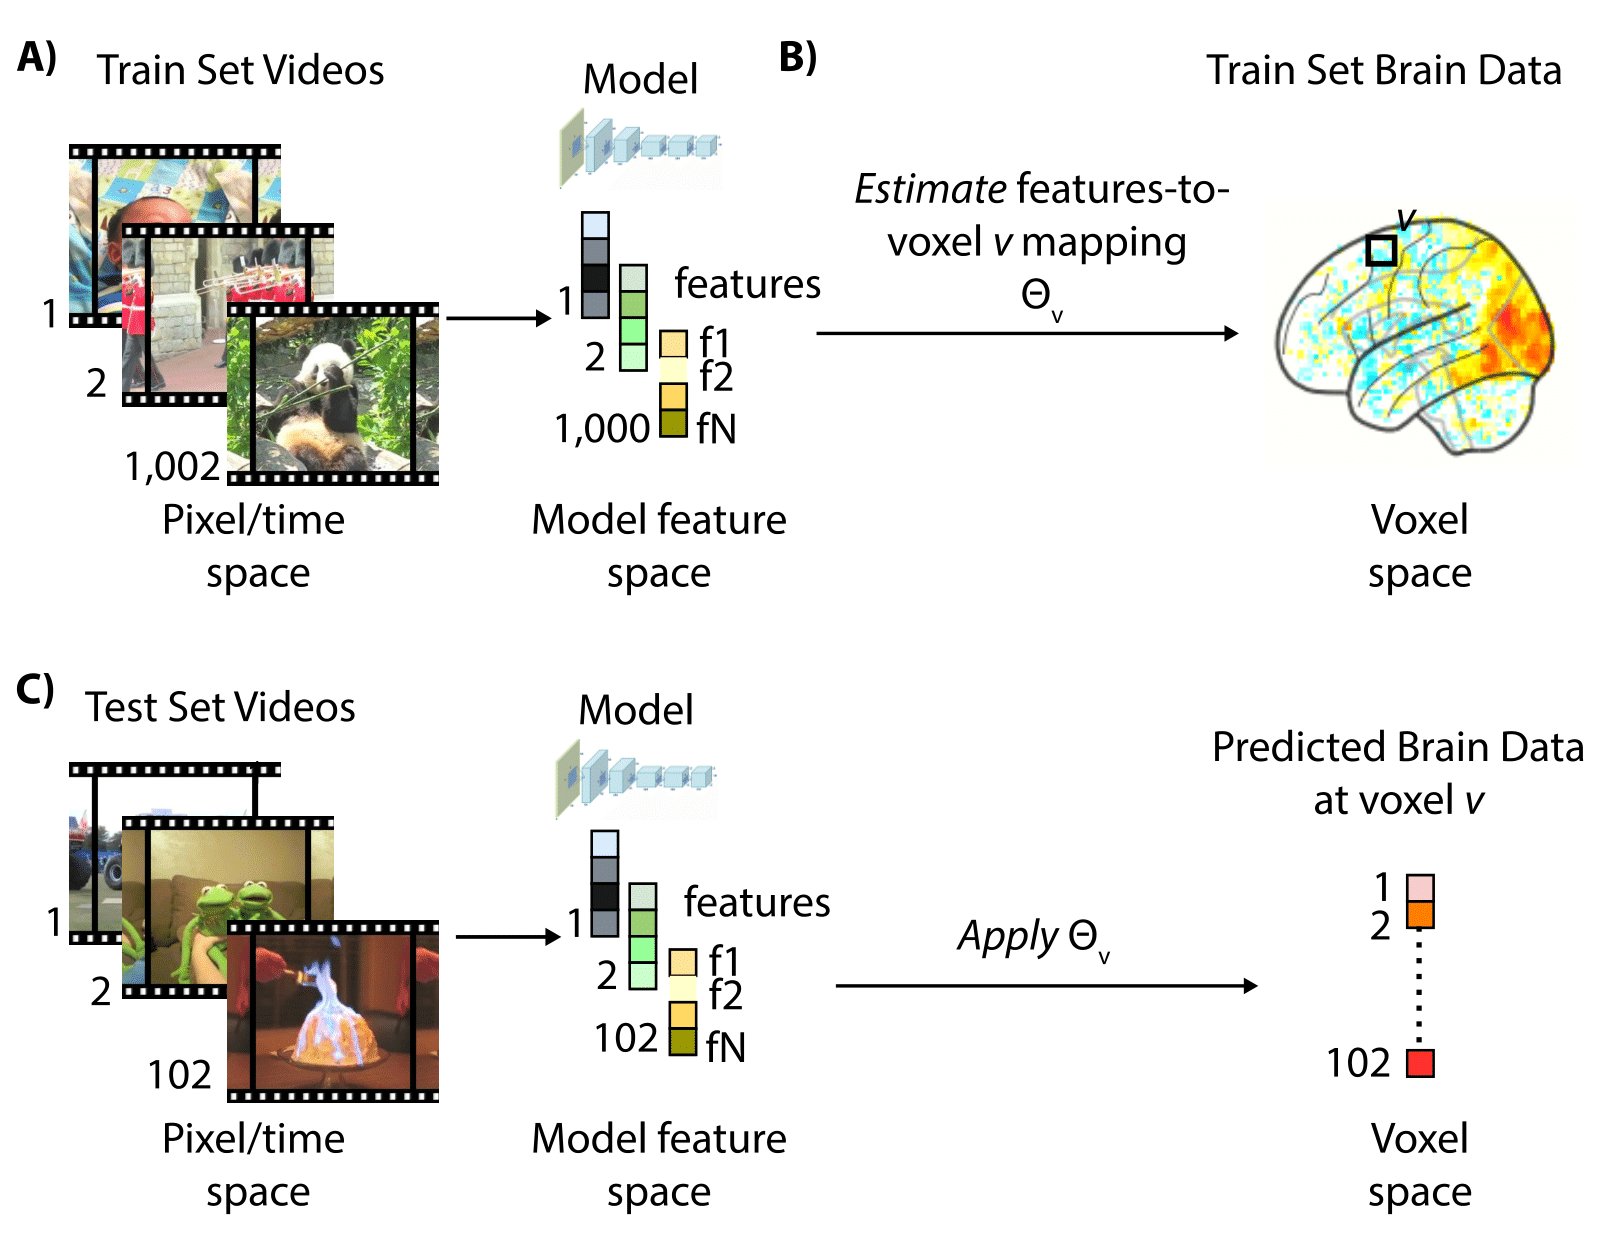

**Figure 1**: **A)** First, given the training set videos, the features of a computational model are extracted. **B)** A mapping between model features and brain voxels is estimated from the Training Set videos. **C)** A mapping between model features and brain voxels is generated on the test set videos, therefore, generating a predicted voxel v's activity for a given video.

## Evaluation

To determine how well a model predicts brain responses we compare synthetic brain data (i.e. those predicted from your model to the left out video clips) to the empirically measured brain responses. The comparison is carried out using Pearson's correlation, comparing for each voxel the 100-dimensional vector formed by the activations for the 100 validation set video clips.

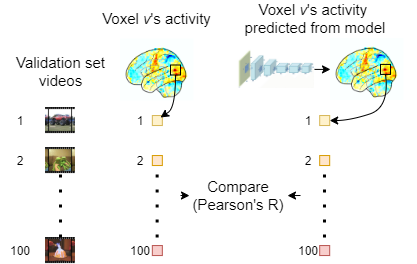

---

## 2-D figures

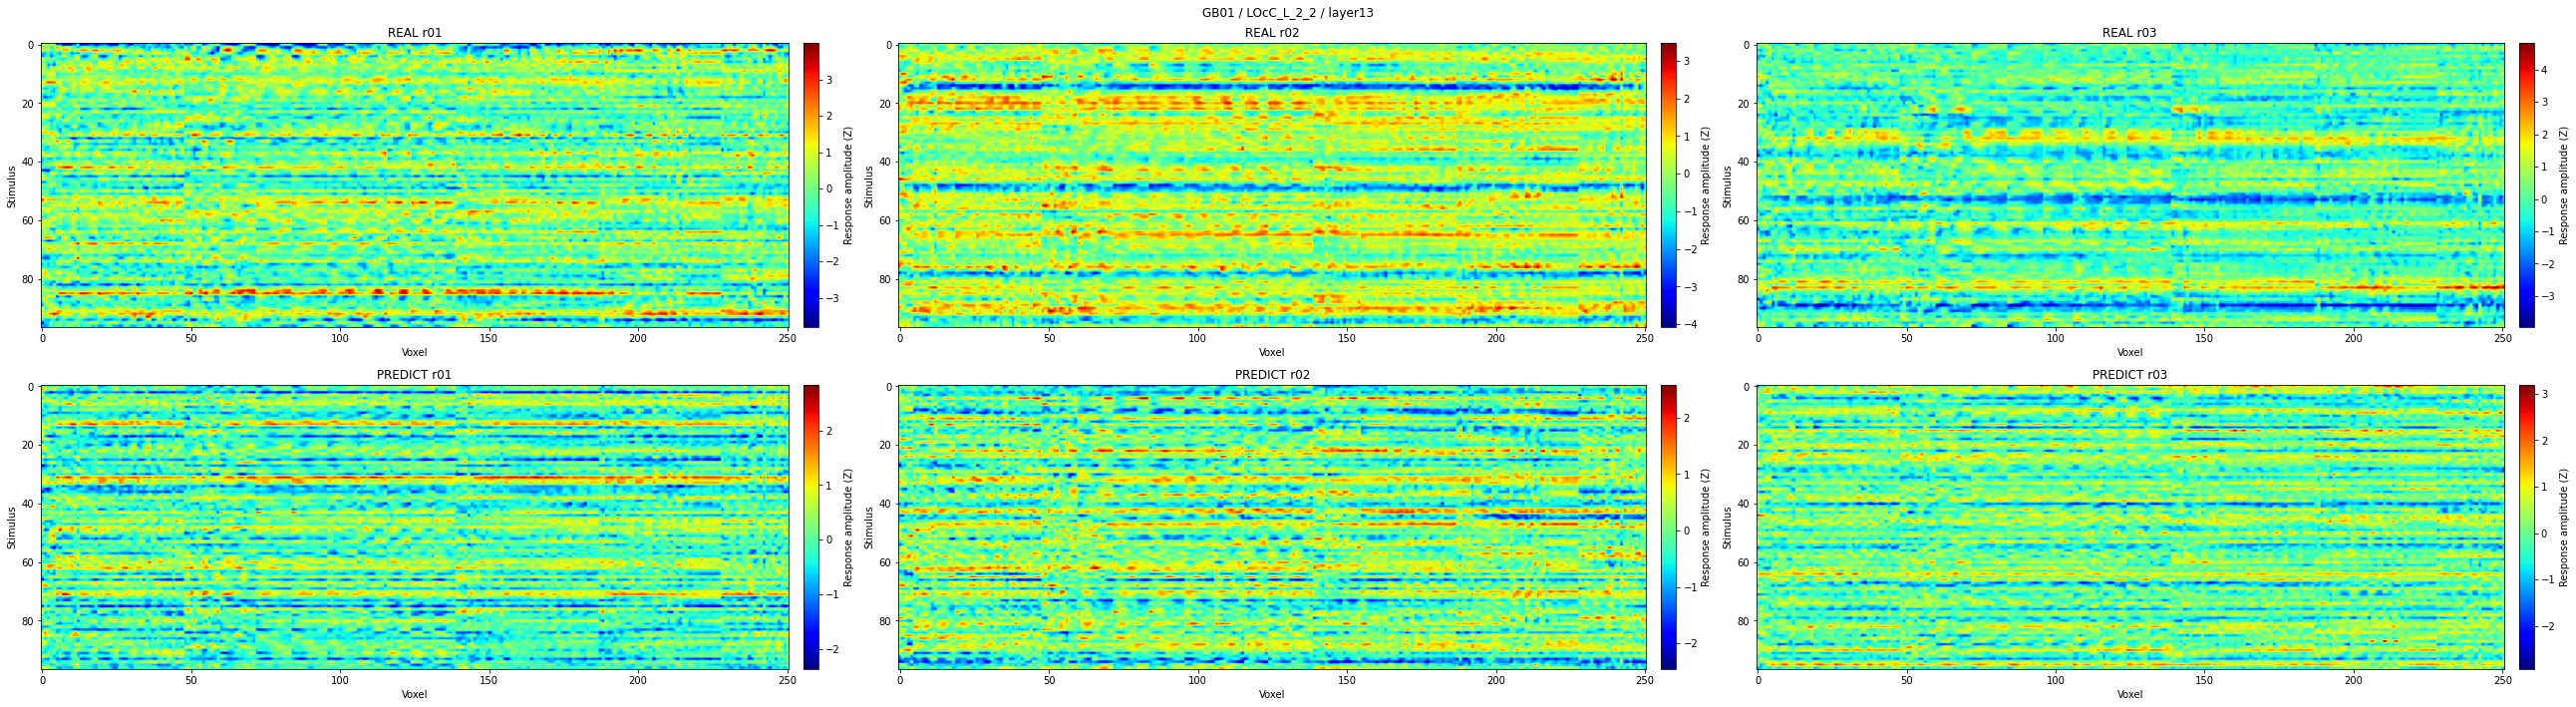

In [82]:
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# layer = 'layer13'
# nframe = 75

# roi = 'LOcC_L_2_2'
# img_mask = GA.roi_imgs[roi]

# subj = '01'
# stage = 'late_practice'
# gg = 'GA' if 'early' in stage else ('GB' if 'late' in stage else 'invalid')

# runs = ['r01', 'r02', 'r03'] if 'practice' in stage else (['r04', 'r05', 'r06'] if 'unpractice' in stage else 'invalid')
# runs = np.array(runs)

# dir_pca = join(GA.dir_work,'results','activations','vgg16','pca')

# fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12*3, 5*2))
# fig.suptitle('%s / %s / %s'%(gg+subj, roi, layer))

# loo = LeaveOneOut()
# for i, (idx_train, idx_test) in enumerate(loo.split(runs)):

#     ## load real fmri data
#     file_fmri = join(GA.dir_fmri, 'preproc_data', subj,'betasLSS.%s%s.%s.nii.gz'%(gg, subj, runs[idx_test][0]))
#     real_fmri = get_fmri(file_fmri, img_mask)
    
#     ax = axs[0,i]
#     ax.set(xlabel="Voxel", ylabel="Stimulus", title='REAL %s'%(runs[idx_test][0]))
#     heatmap = ax.imshow(real_fmri, aspect="auto",cmap='jet')
#     ax_divider = make_axes_locatable(ax)
#     cax = ax_divider.append_axes("right", size="2%", pad="2%")
#     fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)", cax=cax)
    
#     ## load train fmri data
#     preprocessed_img = {}
#     for run in runs[idx_train]:
#         file_fmri = join(GA.dir_fmri, 'preproc_data', subj,'betasLSS.%s%s.%s.nii.gz'%(gg, subj, run))
#         preprocessed_img[run] = get_fmri(file_fmri, img_mask)
#     train_fmri = np.r_[preprocessed_img[runs[idx_train][0]], preprocessed_img[runs[idx_train][1]]]
    
#     ## load activations
#     train_activations, test_activations = get_activations(join(dir_pca, subj), run, layer, nframe)
    
#     ## calculated predict fmri
#     pred_fmri = predict_fmri_fast(train_activations, test_activations, train_fmri)
    
#     ax = axs[1,i]
#     ax.set(xlabel="Voxel", ylabel="Stimulus", title='PREDICT %s'%(runs[idx_test][0]))
#     heatmap = ax.imshow(pred_fmri, aspect="auto",cmap='jet')
#     ax_divider = make_axes_locatable(ax)
#     cax = ax_divider.append_axes("right", size="2%", pad="2%")
#     fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)", cax=cax)
    
# fig.tight_layout()

---

# Review

In [ ]:
dir_eval = join(GA.dir_work, 'results', )
nilearn.plotting.plot_glass_brain()